# PROJECT: Customer Segmentation and Churn Prediction

# STEP 1: Load and Explore Dataset

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Read the Dataset

In [45]:
df = pd.read_csv(r"C:\Users\sgand\OneDrive\Documents\Data Analysis\Python\Customer Segmentation and Churn Prediction\ecommerce-data.csv")

# Basic Cleanup

In [58]:
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# STEP 2: RFM Analysis

In [61]:
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

# STEP 3: Scaling and Clustering

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow Method

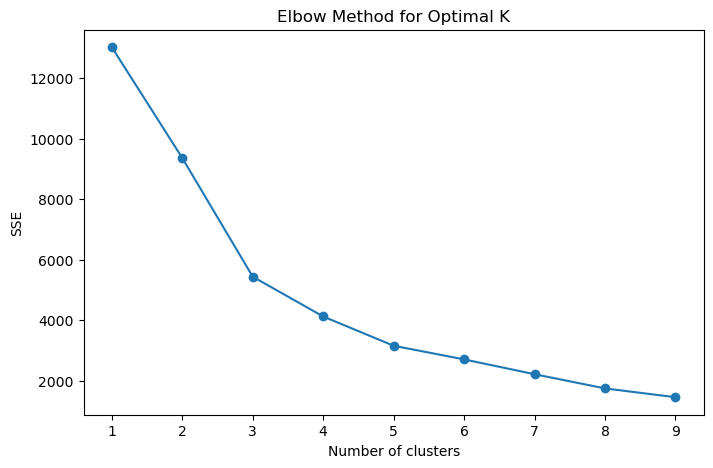

In [69]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(8,5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Apply KMeans with K=4

In [77]:
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize Clusters

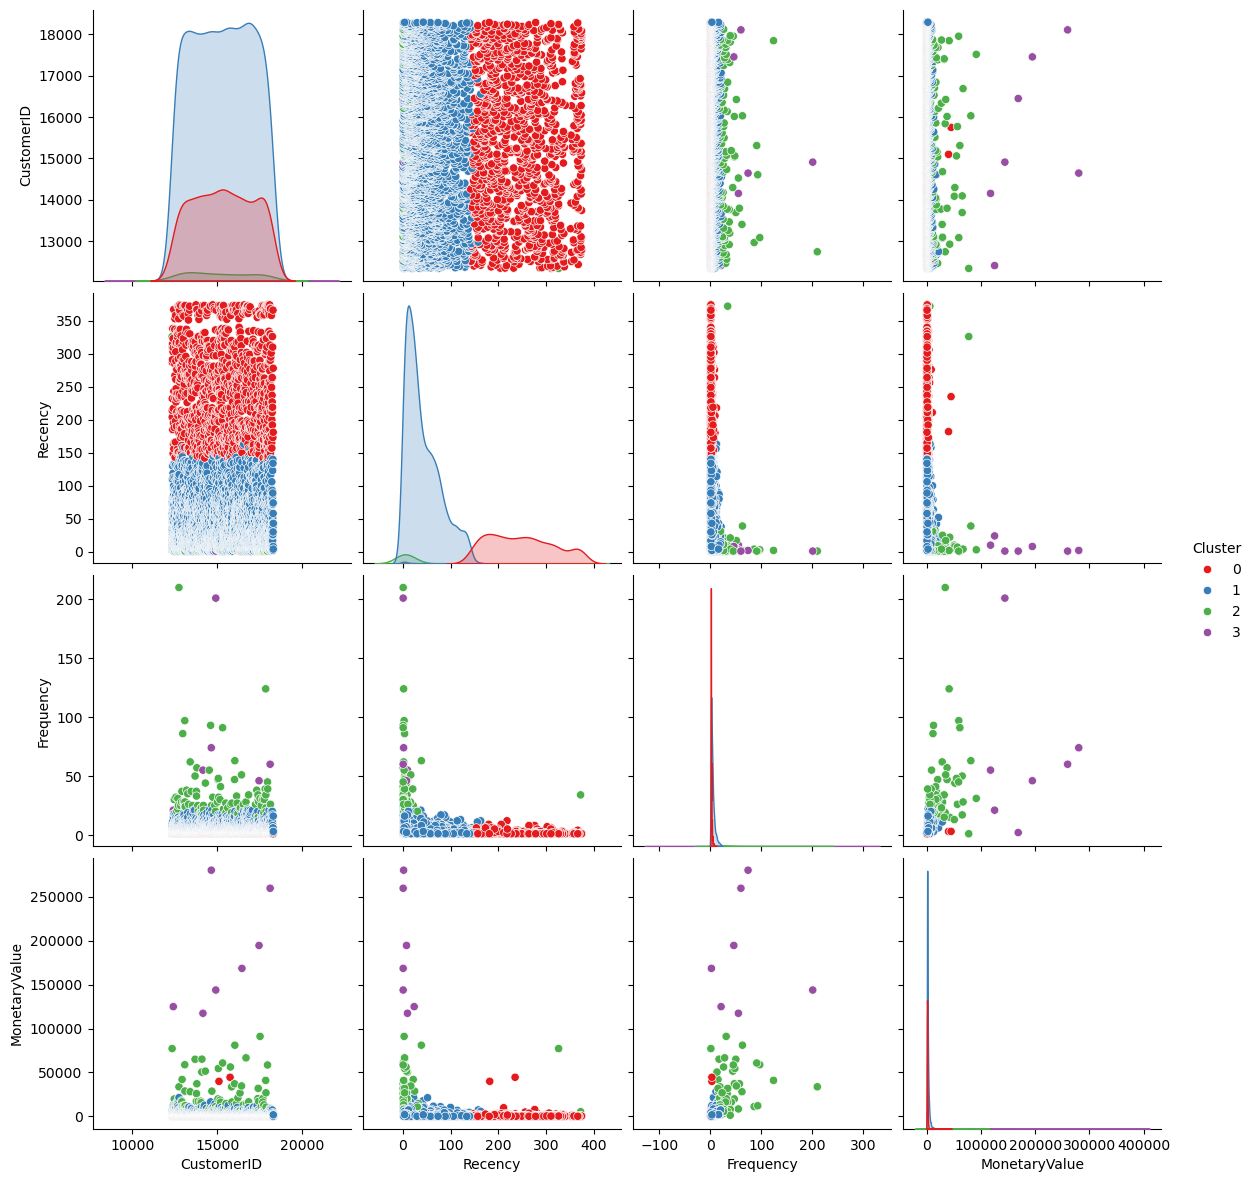

In [101]:
sns.pairplot(rfm.reset_index(), hue='Cluster', palette='Set1', height=3)
plt.savefig(r"C:\Users\sgand\OneDrive\Documents\Data Analysis\Python\Customer Segmentation and Churn Prediction/clusters_plot.png")

# STEP 4: Churn Prediction

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

# Define Churn Label (Recency > 180 days)

In [103]:
rfm['Churn'] = rfm['Recency'].apply(lambda x: 1 if x > 180 else 0)

# Train/Test Split

In [104]:
X = rfm[['Recency', 'Frequency', 'MonetaryValue']]
y = rfm['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Model

In [106]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

# Evaluate

In [108]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1063
           1       1.00      1.00      1.00       239

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



# Save Model

In [110]:
joblib.dump(model, r"C:\Users\sgand\OneDrive\Documents\Data Analysis\Python\Customer Segmentation and Churn Prediction/customer-segmentation-churn_model.pkl")

['C:\\Users\\sgand\\OneDrive\\Documents\\Data Analysis\\Python\\Customer Segmentation and Churn Prediction/customer-segmentation-churn_model.pkl']